# HCC Survival Data 

## Table of Content

1. [Problem Statement](#section1)<br>
2. [Data Loading and Description](#section2)<br>
3. [Exploratory Data Analysis](#section3)<br>
4. [Cross Validation](#section4)<br>
5. [Data Engineering](#section5)<br>
    - 5.1 [Dealing with missing values in both train & test data](#section501)<br>
    - 5.2 [Outlier Treatment](#section502)<br>
    - 5.3 [Checking Correlations among the Explanatory variables](#section503)<br>
    - 5.4 [Scaling the data for the continous variables](#section504)<br>
    - 5.5 [One hot encoding on Categorical variables](#section505)<br>
6. [Random Undersampling and Oversampling](#section5)<br>
    - 6.1 [Random UnderSampling](#section601)<br>
    - 6.2 [Getting the scores of the data using Random Undersampling](#section602)<br>
    - 6.3 [Oversampling using SMOTE(Synthetic Minority Oversampling Technique)](#section603)<br>
    - 6.4 [Getting the scores of the data using Random Oversampling (SMOTE)](#section604)<br>
7. [Conclusion](#section7)<br>

## 1. Problem Statement

- To classify the patient with the given diagnosis into Survival(0) or not(1)
- Which model fits better provided given hcc data?

## 2. Data Loading and Description

HCC dataset was obtained at a University Hospital in Portugal and contais several demographic, risk factors, laboratory and overall survival features of 165 real patients diagnosed with HCC. The dataset contains 49 features selected according to the EASL-EORTC (European Association for the Study of the Liver - European Organisation for Research and Treatment of Cancer) Clinical Practice Guidelines, which are the current state-of-the-art on the management of HCC. 

This is an heterogeneous dataset, with 23 quantitative variables, and 26 qualitative variables. Overall, missing data represents 10.22% of the whole dataset and only eight patients have complete information in all fields (4.85%). The target variables is the survival at 1 year, and was encoded as a binary variable: 0 (dies) and 1 (lives). A certain degree of class-imbalance is also present

#### Importing Packages

In [1]:
#Imported Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC


#Other Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score


#### Importing the Dataset

In [2]:
hcc_data = pd.read_csv('C:\\Users\\VijayMukkala\\Desktop\\Kaggle\\hcc-survival-data-set\hcc.csv')
hcc_data.head()

,Gender,Symptoms,Alcohol,Hepatitis B Surface Antigen,Hepatitis B e Antigen,Hepatitis B Core Antibody,Hepatitis C Virus Antibody,Cirrhosis,Endemic Countries,Smoking,...,Alkaline phosphatase (U/L),Total Proteins (g/dL),Creatinine (mg/dL),Number of Nodules,Major dimension of nodule (cm),Direct Bilirubin (mg/dL),Iron (mcg/dL),Oxygen Saturation (%),Ferritin (ng/mL),Class
0,1,0,1,0,0,0,0,1,0,1,...,150,7.1,0.7,1,3.5,0.5,?,?,?,1
1,0,?,0,0,0,0,1,1,?,?,...,?,?,?,1,1.8,?,?,?,?,1
2,1,0,1,1,0,1,0,1,0,1,...,109,7,2.1,5,13,0.1,28,6,16,1
3,1,1,1,0,0,0,0,1,0,1,...,174,8.1,1.11,2,15.7,0.2,?,?,?,0
4,1,1,1,1,0,1,0,1,0,1,...,109,6.9,1.8,1,9,?,59,15,22,1


- If we use the imbalanced data as base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most people __survived__. But we don't want our model to assume.
- We gonna deal with this in this notebook

## 3. Exploratory Data Analysis

In [3]:
print('Shape of the dataset :',hcc_data.shape)

Shape of the dataset : (165, 50)


In [4]:
hcc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
Gender                              165 non-null int64
Symptoms                            165 non-null object
Alcohol                             165 non-null int64
Hepatitis B Surface Antigen         165 non-null object
Hepatitis B e Antigen               165 non-null object
Hepatitis B Core Antibody           165 non-null object
Hepatitis C Virus Antibody          165 non-null object
Cirrhosis                           165 non-null int64
Endemic Countries                   165 non-null object
Smoking                             165 non-null object
Diabetes                            165 non-null object
Obesity                             165 non-null object
Hemochromatosis                     165 non-null object
Arterial Hypertension               165 non-null object
Chronic Renal Insufficiency         165 non-null object
Human Immunodeficiency Virus        165 non-null object
No

In [5]:
# To check on the statistics
hcc_data.describe()

,Gender,Alcohol,Cirrhosis,Age at diagnosis,Performance Status,Class
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,0.806061,0.739394,0.903030,64.690909,1.018182,0.618182
std,0.396586,0.440302,0.296817,13.319534,1.181528,0.487311
min,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,57.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,66.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,74.000000,2.000000,1.000000
max,1.000000,1.000000,1.000000,93.000000,4.000000,1.000000


- Replacing '?' with Nan for computation
- Dropping duplicates from the dataset

In [6]:
# Replace '?' with Nan
hcc_data = hcc_data.replace('?', np.NaN)
hcc_data.head()

,Gender,Symptoms,Alcohol,Hepatitis B Surface Antigen,Hepatitis B e Antigen,Hepatitis B Core Antibody,Hepatitis C Virus Antibody,Cirrhosis,Endemic Countries,Smoking,...,Alkaline phosphatase (U/L),Total Proteins (g/dL),Creatinine (mg/dL),Number of Nodules,Major dimension of nodule (cm),Direct Bilirubin (mg/dL),Iron (mcg/dL),Oxygen Saturation (%),Ferritin (ng/mL),Class
0,1,0,1,0,0,0,0,1,0,1,...,150,7.1,0.7,1,3.5,0.5,NaN,NaN,NaN,1
1,0,NaN,0,0,0,0,1,1,NaN,NaN,...,NaN,NaN,NaN,1,1.8,NaN,NaN,NaN,NaN,1
2,1,0,1,1,0,1,0,1,0,1,...,109,7,2.1,5,13,0.1,28,6,16,1
3,1,1,1,0,0,0,0,1,0,1,...,174,8.1,1.11,2,15.7,0.2,NaN,NaN,NaN,0
4,1,1,1,1,0,1,0,1,0,1,...,109,6.9,1.8,1,9,NaN,59,15,22,1


## 4. Cross Validation 
Splitting the data into train and test for X(Explanatory varaibales) & y(Target variables) .
Cross validating the data at the start will make the test data foreign to the model and hence avoiding the overfitting`

#### Preparing X and y using pandas

In [7]:
X = hcc_data.loc[:,hcc_data.columns != 'Class']
X.head()

,Gender,Symptoms,Alcohol,Hepatitis B Surface Antigen,Hepatitis B e Antigen,Hepatitis B Core Antibody,Hepatitis C Virus Antibody,Cirrhosis,Endemic Countries,Smoking,...,Gamma glutamyl transferase (U/L),Alkaline phosphatase (U/L),Total Proteins (g/dL),Creatinine (mg/dL),Number of Nodules,Major dimension of nodule (cm),Direct Bilirubin (mg/dL),Iron (mcg/dL),Oxygen Saturation (%),Ferritin (ng/mL)
0,1,0,1,0,0,0,0,1,0,1,...,183,150,7.1,0.7,1,3.5,0.5,NaN,NaN,NaN
1,0,NaN,0,0,0,0,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1.8,NaN,NaN,NaN,NaN
2,1,0,1,1,0,1,0,1,0,1,...,202,109,7,2.1,5,13,0.1,28,6,16
3,1,1,1,0,0,0,0,1,0,1,...,94,174,8.1,1.11,2,15.7,0.2,NaN,NaN,NaN
4,1,1,1,1,0,1,0,1,0,1,...,173,109,6.9,1.8,1,9,NaN,59,15,22


In [8]:
y = hcc_data['Class']
y.head()

0    1
1    1
2    1
3    0
4    1
Name: Class, dtype: int64

### Splittig X & y into test and train (Cross-Validaton)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(132, 49)
(33, 49)
(132,)
(33,)


## 5. Data Engineering

### 5.1 Dealing with missing values in both train & test data

In [10]:
# checking the missing values
X_train.isnull().sum()

Gender                               0
Symptoms                            17
Alcohol                              0
Hepatitis B Surface Antigen         12
Hepatitis B e Antigen               27
Hepatitis B Core Antibody           17
Hepatitis C Virus Antibody           7
Cirrhosis                            0
Endemic Countries                   32
Smoking                             36
Diabetes                             2
Obesity                              7
Hemochromatosis                     16
Arterial Hypertension                1
Chronic Renal Insufficiency          1
Human Immunodeficiency Virus        10
Nonalcoholic Steatohepatitis        15
Esophageal Varices                  42
Splenomegaly                        12
Portal Hypertension                 10
Portal Vein Thrombosis               3
Liver Metastasis                     4
Radiological Hallmark                2
Age at diagnosis                     0
Grams of Alcohol per day            38
Packs of cigarets per yea

For the values which are more than 50% we are gonna remove and the values which are less than 50 % , for numerical values we are gonna replace with Mean and for categorical values we are gonna replace with Median

In [11]:
# Dropping columns more than 50% which are 'Oxygen Saturation (%)', 'Ferritin (ng/mL)','Iron (mcg/dL)'

X_train = X_train.drop(['Oxygen Saturation (%)', 'Ferritin (ng/mL)','Iron (mcg/dL)'],1)
X_test = X_test.drop(['Oxygen Saturation (%)', 'Ferritin (ng/mL)','Iron (mcg/dL)'],1)

In [12]:
# Creating list diving categorical and continous features
continous = ['International Normalised Ratio', 'Alpha-Fetoprotein (ng/mL)','Haemoglobin (g/dL)', 'Mean Corpuscular Volume (fl)', 'Leukocytes(G/L)',
'Platelets (G/L)', 'Albumin (mg/dL)', 'Total Bilirubin(mg/dL)','Alanine transaminase (U/L)', 'Aspartate transaminase (U/L)',
'Gamma glutamyl transferase (U/L)', 'Alkaline phosphatase (U/L)','Total Proteins (g/dL)', 'Creatinine (mg/dL)','Major dimension of nodule (cm)', 'Direct Bilirubin (mg/dL)', 'Grams of Alcohol per day',
'Packs of cigarets per year','Age at diagnosis', 'Number of Nodules']
cat = ['Gender', 'Symptoms', 'Alcohol', 'Hepatitis B Surface Antigen','Hepatitis B e Antigen', 'Hepatitis B Core Antibody',
'Hepatitis C Virus Antibody', 'Cirrhosis', 'Endemic Countries','Smoking', 'Diabetes', 'Obesity', 'Hemochromatosis',
'Arterial Hypertension', 'Chronic Renal Insufficiency','Human Immunodeficiency Virus', 'Nonalcoholic Steatohepatitis',
'Esophageal Varices', 'Splenomegaly', 'Portal Hypertension','Portal Vein Thrombosis', 'Liver Metastasis', 'Radiological Hallmark','Performance Status','Encefalopathy degree','Ascites degree']

In [13]:
# User defined function for changing the datatypes of columns
def convert_dtype(data):
    for col in data.columns:
        if col in continous:
            data[col] = data[col].convert_objects(convert_numeric=True)
        elif col in cat:
            data[col] = data[col].astype('category')
        else:
            data[col] = data[col]
    return

In [14]:
# Implementing the user defined function on both Train and test data
convert_dtype(X_train)
convert_dtype(X_test)

c:\users\vijaymukkala\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """


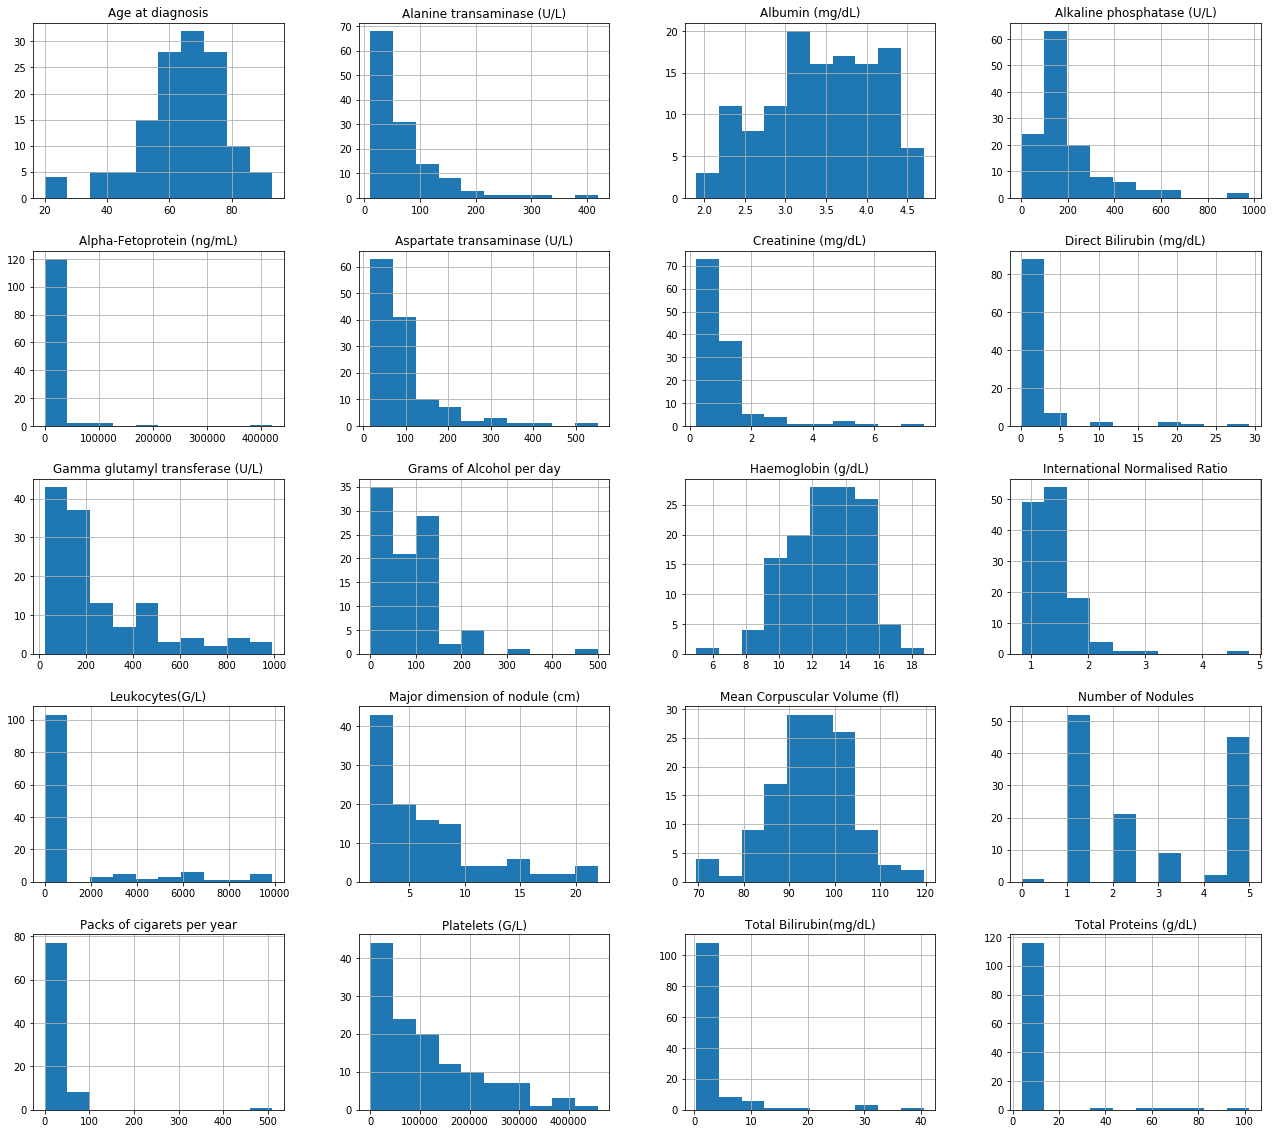

In [15]:
#### Plotting Histogram for better understanding of distibution
X_train.hist(figsize=(22,20))
plt.show()

From the above histogram, the columns: __'Age at diagnosis', 'Albumin (mg/dL)', 'Haemoglobin (g/dL)','Mean Corpuscular Volume (fl)'__ have __uniform distribution__ so the missing values will be replaced by mean. For all other columns as they are skewed the values will be replaced by Median. And for the categorical values the missing values will be replaced by most occuring values(Mode)

In [16]:
mean_list = ['Age at diagnosis', 'Albumin (mg/dL)', 'Haemoglobin (g/dL)','Mean Corpuscular Volume (fl)']

In [17]:
#User defined function to deal with missing values
def missing_data(data):
    for col in data.columns:
        if col in mean_list:
            data[col] = data[col].fillna(data[col].mean())
        elif col in cat:
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            data[col] = data[col].fillna(data[col].median())
    return

In [18]:
# Applying the user defined function for missing values and applying on Train and test
missing_data(X_train)
missing_data(X_test)
print(X_train.shape)
print(X_test.shape)

(132, 46)
(33, 46)


In [19]:
print('Any Misisng values in Train :',X_train.isnull().sum().any())
print('Any Misisng values in Test :',X_test.isnull().sum().any())


Any Misisng values in Train : False
Any Misisng values in Test : False


### Plotting the distribution of all the continous Expalnatory variables

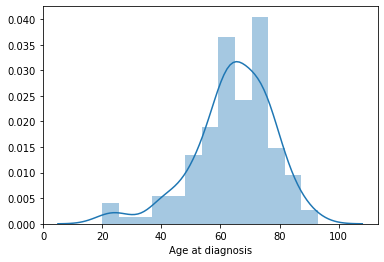

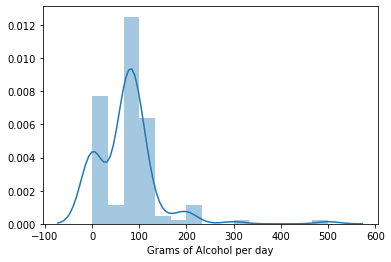

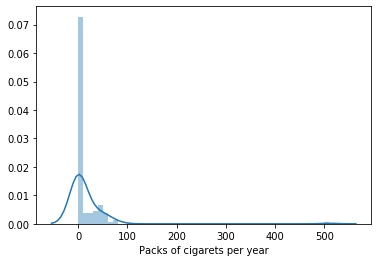

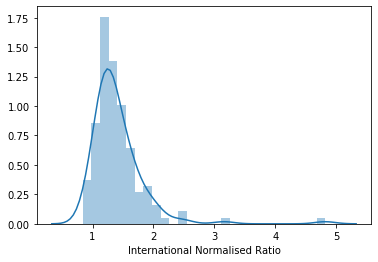

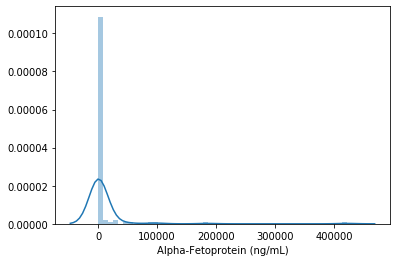

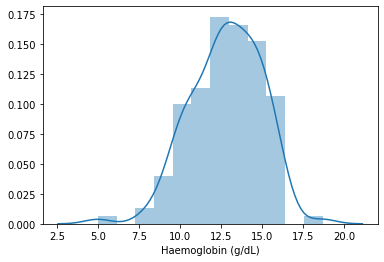

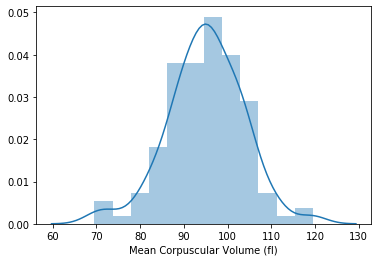

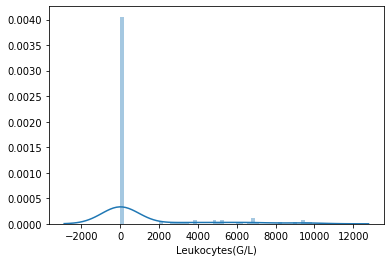

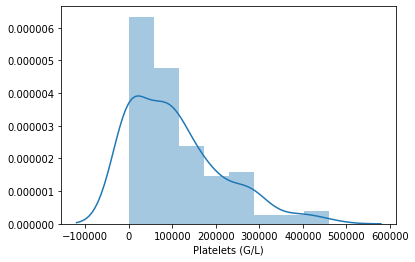

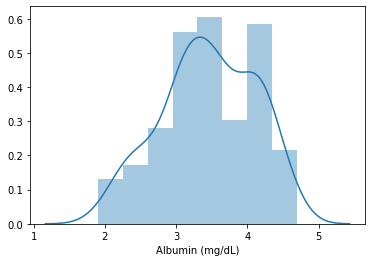

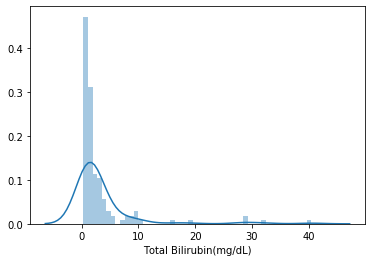

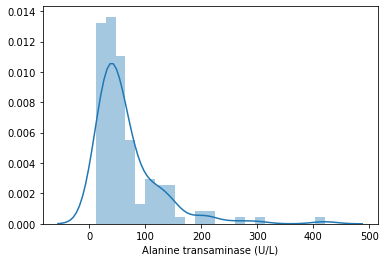

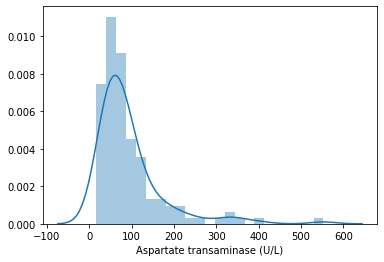

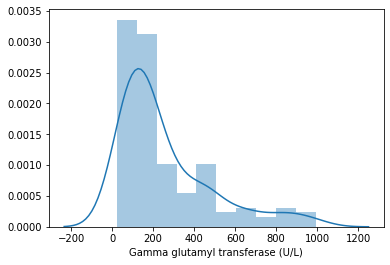

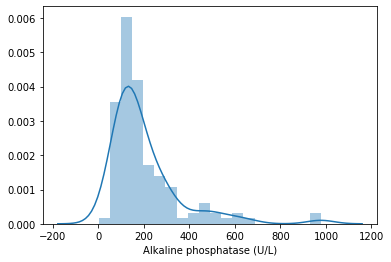

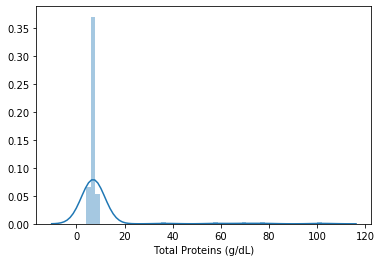

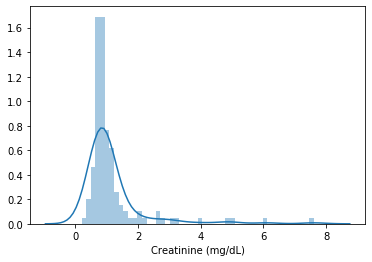

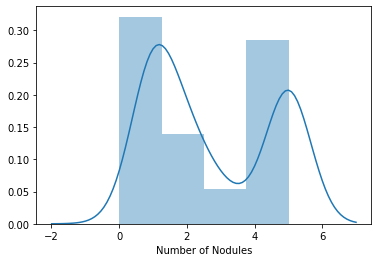

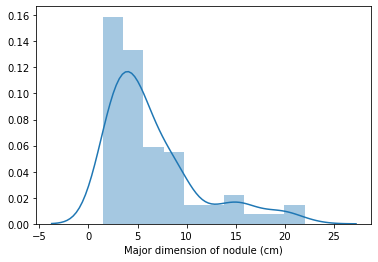

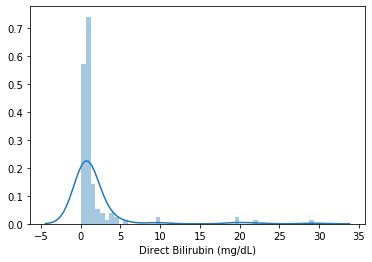

In [20]:
for i, col in enumerate(X_train.dtypes[X_train.dtypes != 'category'].index):
    plt.figure(i)
    sns.distplot(X_train[col])

From the distribution plot and bar charts, we see that __Alpha-Fetoprotein (ng/mL) and Leukocytes(G/L)__ have __more zero values__.
These columns will be dropped as these are not useful for furthr analysis

In [21]:
# Dropping the columns for both train and test
X_train = X_train.drop(['Alpha-Fetoprotein (ng/mL)','Leukocytes(G/L)'],1)
X_test = X_test.drop(['Alpha-Fetoprotein (ng/mL)','Leukocytes(G/L)'],1)

### 5.2 Outlier Treatment 
We will use a technique called __Capping or Censoring__ capping the maximum and /or minimum of a distribution at an arbitrary value. On other words, values bigger or smaller than the arbitrarily determined ones are __censored__.

The numbers at which to cap the distribution can be determined using the inter-quantal range proximity rule

#### Plotting the data with Boxplot 

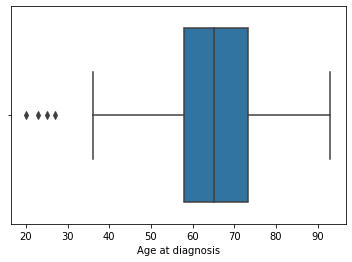

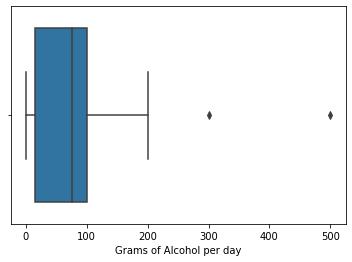

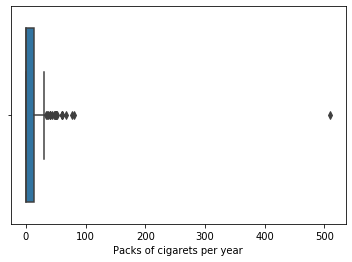

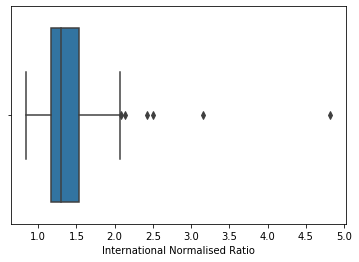

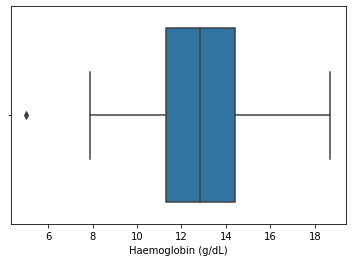

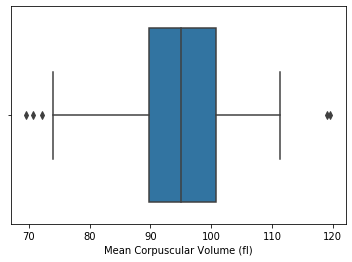

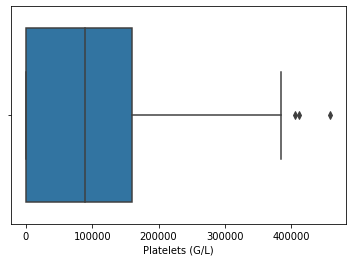

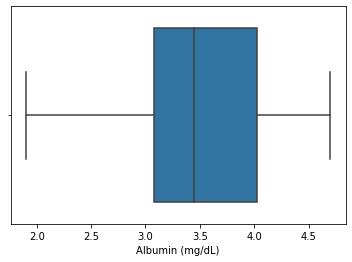

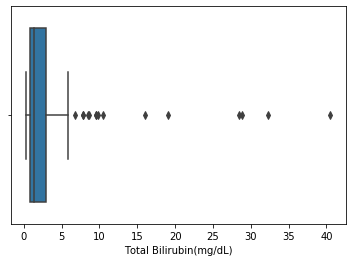

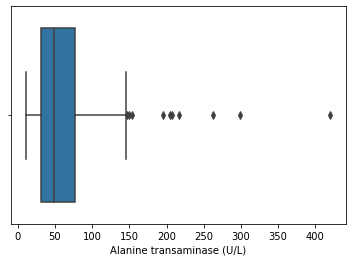

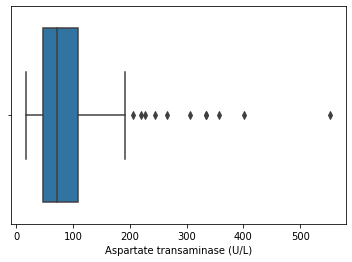

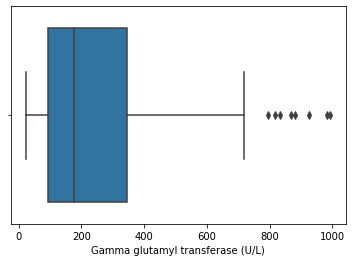

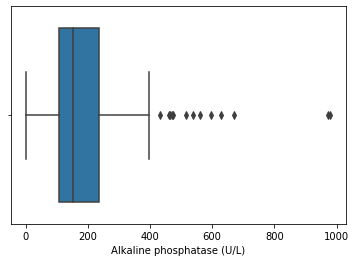

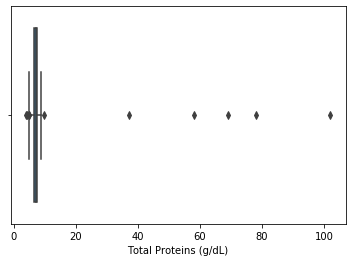

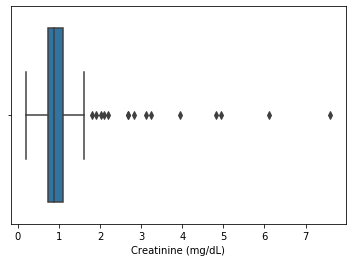

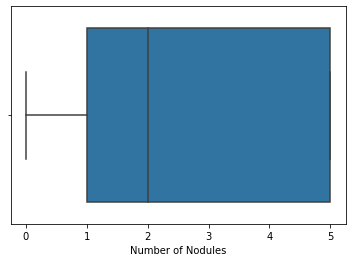

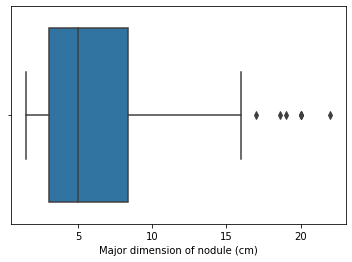

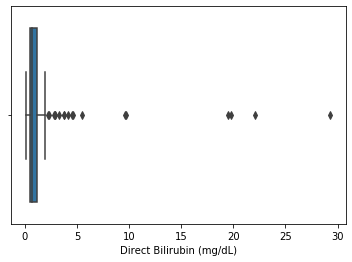

In [22]:
for i, col in enumerate(X_train.dtypes[X_train.dtypes != 'category'].index):
    plt.figure(i)
    sns.boxplot(X_train[col])

In [23]:
# User defined function to deal with outliers using capping method
def outliers(data):
    for col in data.columns:
        if col in continous:
            IQR = data[col].quantile(0.75)- data[col].quantile(0.25)
            lower_boundary = data[col].quantile(0.25) - 1.5 * IQR
            upper_boundary = data[col].quantile(0.75) + 1.5 * IQR
            data[col] = np.where(data[col]> upper_boundary, upper_boundary,
                             np.where(data[col] < lower_boundary, lower_boundary, data[col]))
        else:
            data[col] = data[col]
    return

In [24]:
# Applying the outlier defined function on train and test data
outliers(X_train)
outliers(X_test)

#### Plotting the Boxplot after outlier treatment

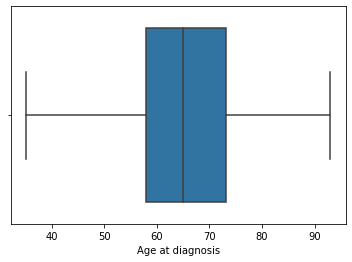

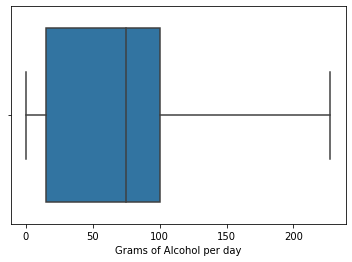

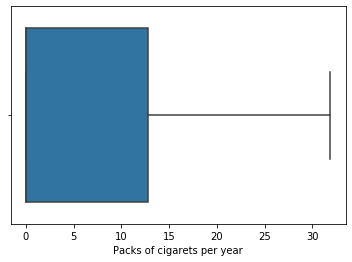

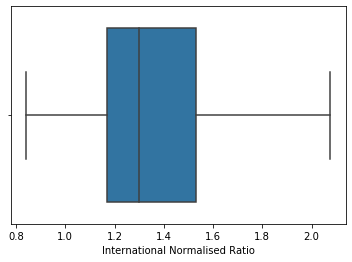

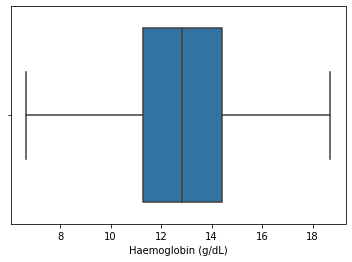

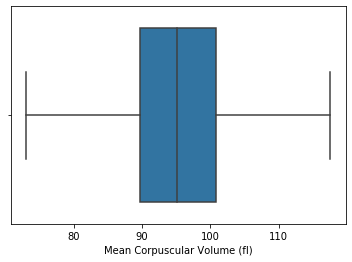

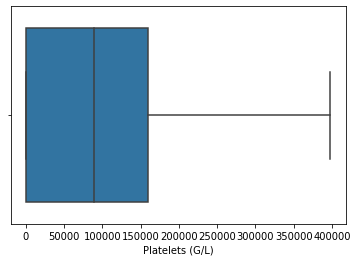

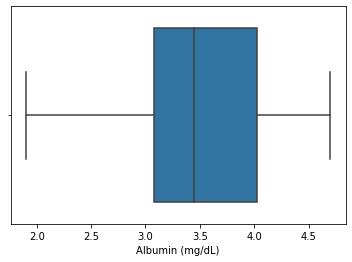

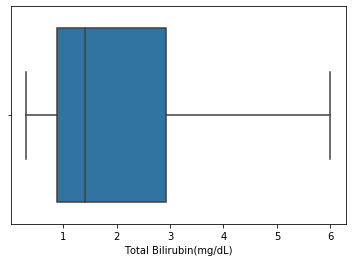

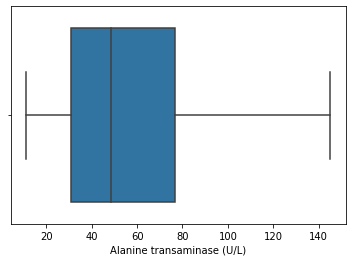

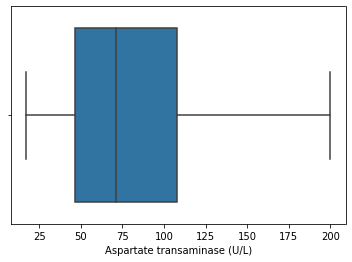

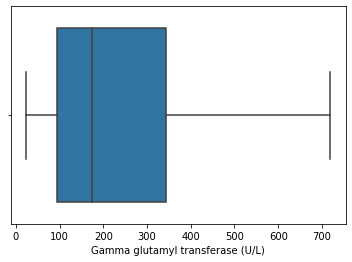

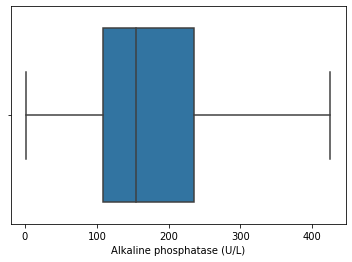

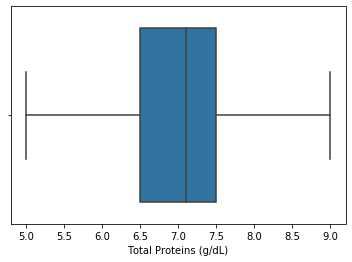

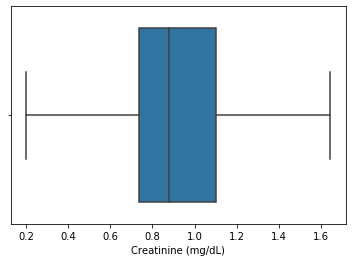

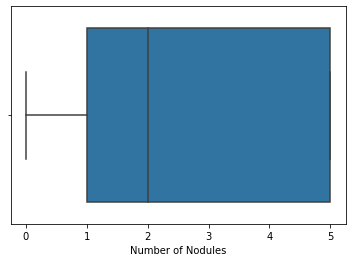

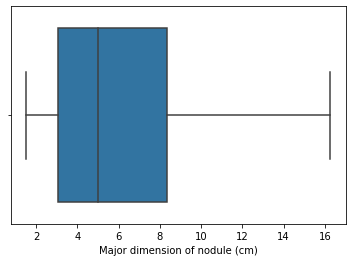

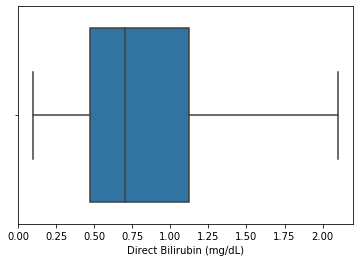

In [25]:
for i, col in enumerate(X_train.dtypes[X_train.dtypes != 'category'].index):
    plt.figure(i)
    sns.boxplot(X_train[col])

### 5.3 Checking Correlations among the Explanatory variables

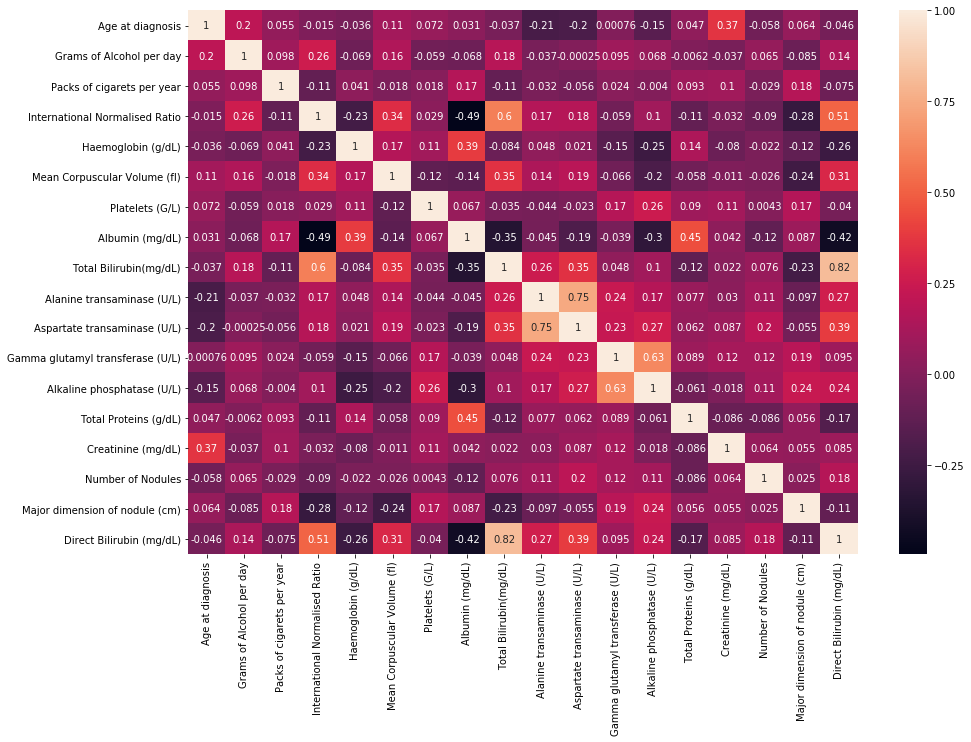

In [26]:
corr = X_train.corr()
plt.figure(figsize= (15,10))
sns.heatmap(corr, annot = True)
plt.show()

From the heatmap , we can infer that 'Total Bilirubin(mg/dL)' is highly correlated with other explanatory variables . So we are gonna drop.

In [27]:
# Dropping the columns for both train and test
X_train = X_train.drop(['Total Bilirubin(mg/dL)'],1)
X_test = X_test.drop(['Total Bilirubin(mg/dL)'],1)

Diving the X_train and X_test into categorical and Continous data:

In [28]:
hcc_train_cont = X_train.loc[:,X_train.dtypes != 'category']
hcc_train_cat = X_train.loc[:,X_train.dtypes == 'category']
hcc_test_cont = X_test.loc[:,X_test.dtypes != 'category']
hcc_test_cat = X_test.loc[:,X_test.dtypes == 'category']

### 5.4 Scaling the data for the continous variables

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(hcc_train_cont)

hcc_train_cont = pd.DataFrame(scaler.transform(hcc_train_cont), columns= hcc_train_cont.columns)
#Scaling the test data 
hcc_test_cont = pd.DataFrame(scaler.transform(hcc_test_cont), columns= hcc_test_cont.columns)


In [30]:
# Preview the continous data for train after scaling
hcc_train_cont.head()

,Age at diagnosis,Grams of Alcohol per day,Packs of cigarets per year,International Normalised Ratio,Haemoglobin (g/dL),Mean Corpuscular Volume (fl),Platelets (G/L),Albumin (mg/dL),Alanine transaminase (U/L),Aspartate transaminase (U/L),Gamma glutamyl transferase (U/L),Alkaline phosphatase (U/L),Total Proteins (g/dL),Creatinine (mg/dL),Number of Nodules,Major dimension of nodule (cm),Direct Bilirubin (mg/dL)
0,1.486987,0.584982,-0.592671,0.353049,-0.066429,1.294711,-1.013217,-8.450618e-01,-0.675531,-0.627030,-0.447051,0.200399,0.209102,-0.243454,-0.403541,-0.528386,0.834964
1,1.568348,1.549721,-0.592671,1.237185,0.123869,1.886848,2.344019,-1.612193e+00,-0.875731,-0.351898,-0.686446,1.179876,-1.496004,-0.035478,-0.970216,0.882153,-0.324151
2,0.347940,0.102613,-0.592671,-0.599097,0.314168,1.164441,-1.012126,8.426264e-01,-0.750606,-0.116071,-0.596673,-0.948603,0.635378,-0.481140,-0.970216,0.164930,-0.820914
3,0.510661,0.102613,-0.592671,-1.007160,-0.114004,-1.322533,1.703033,1.362698e-15,-0.825681,-0.764596,-0.875967,0.256907,0.102532,-1.431885,1.296484,-0.313219,-0.324151
4,0.836103,3.045065,-0.592671,0.217028,1.455959,0.986800,-0.047720,-7.793077e-02,-0.850706,0.041147,0.071637,-0.364684,-0.750021,-0.184032,1.296484,-0.958720,1.166140


#### Plot Bar charts for categorical variables

c:\users\vijaymukkala\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


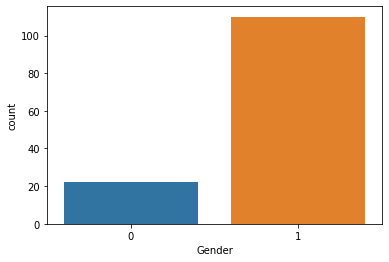

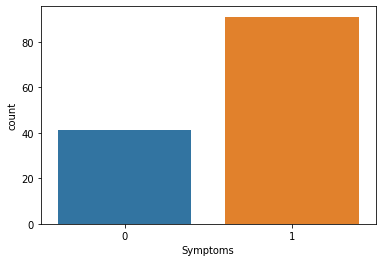

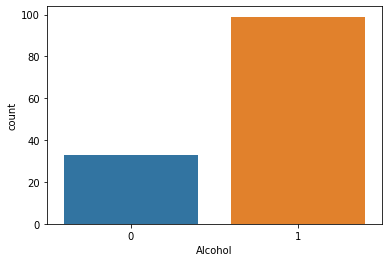

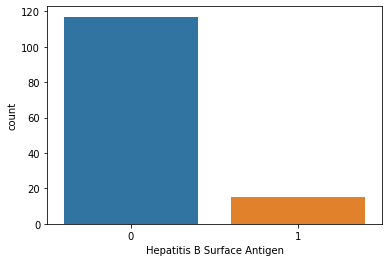

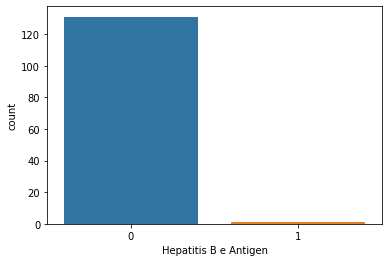

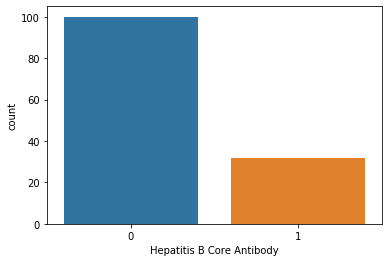

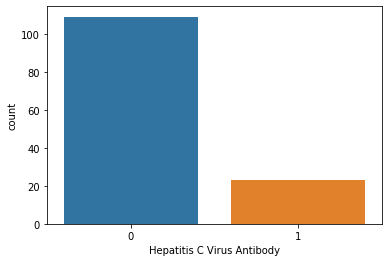

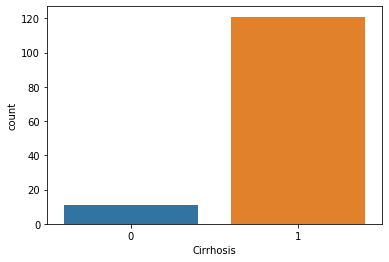

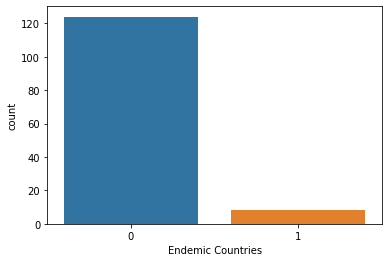

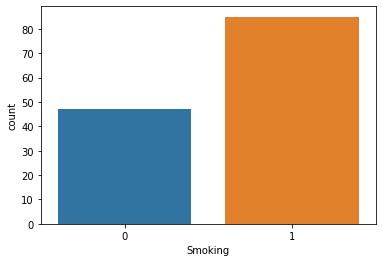

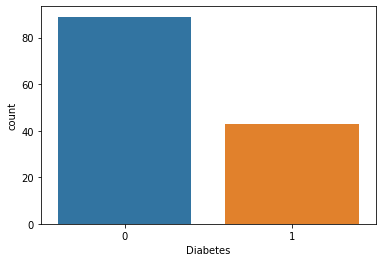

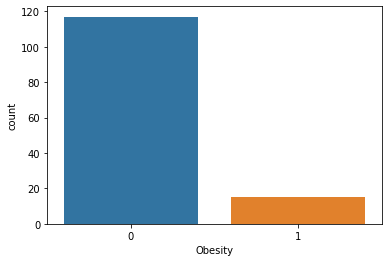

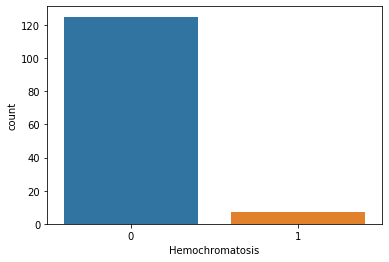

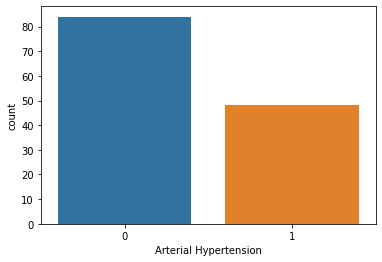

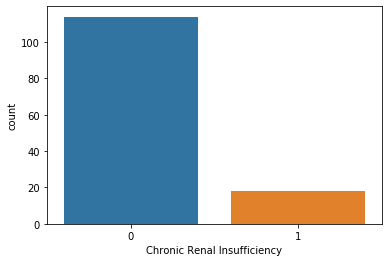

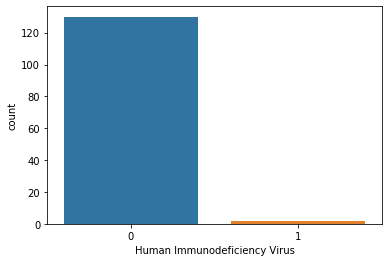

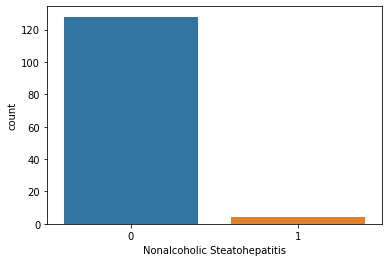

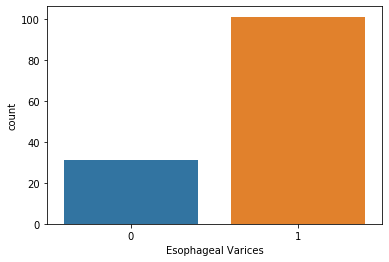

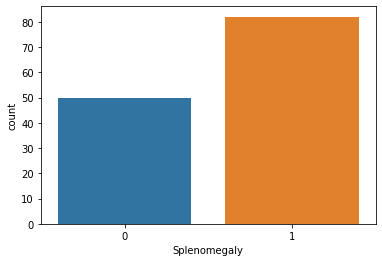

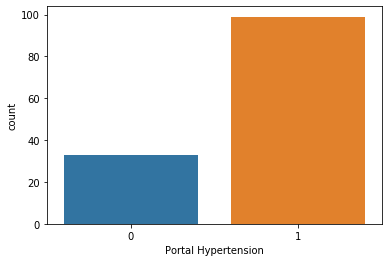

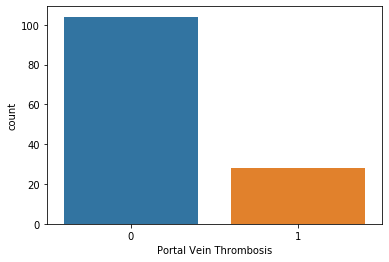

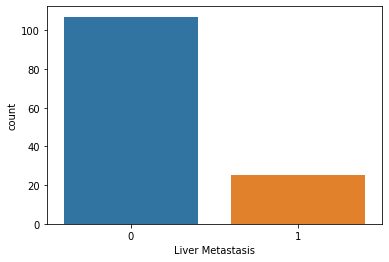

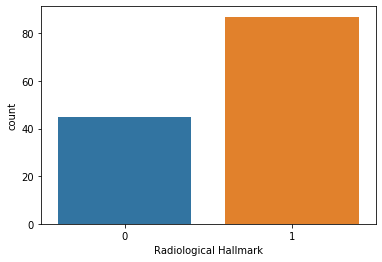

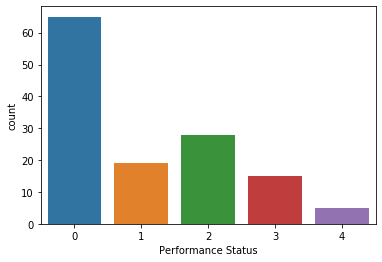

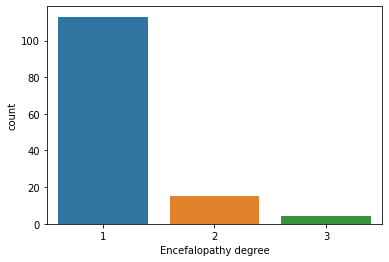

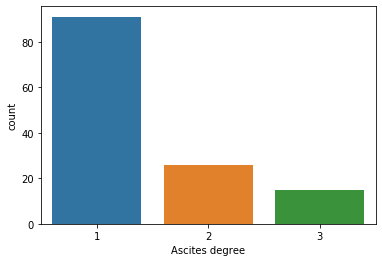

In [31]:
for i,col in enumerate(hcc_train_cat.columns):
    plt.figure(i)
    sns.countplot(hcc_train_cat[col])

Dropping the columns __Hepatitis B e Antigen,Human Immunodeficiency Virus__ as these columns have highly imbalanced data

In [32]:
hcc_train_cat = hcc_train_cat.drop(['Hepatitis B e Antigen','Human Immunodeficiency Virus'],1)
hcc_test_cat = hcc_test_cat.drop(['Hepatitis B e Antigen','Human Immunodeficiency Virus'],1)

In [33]:
# Hemochromatosis , Performance Status, Encefalopathy degree
hcc_train_cat = hcc_train_cat.drop(['Hemochromatosis','Performance Status','Encefalopathy degree'],1)
hcc_test_cat = hcc_test_cat.drop(['Hemochromatosis','Performance Status','Encefalopathy degree'],1)

### 5.5 One hot encoding on Categorical variables
Converting categorical variables into dummies by one hot encoding and removing one column to avoid the trap of dummy variable trap for both train and test data

In [34]:
hcc_train_cat1 = pd.get_dummies(hcc_train_cat, drop_first = True)
hcc_test_cat1 = pd.get_dummies(hcc_test_cat, drop_first = True)

In [35]:
hcc_train_cat1.head()

,Gender_1,Symptoms_1,Alcohol_1,Hepatitis B Surface Antigen_1,Hepatitis B Core Antibody_1,Hepatitis C Virus Antibody_1,Cirrhosis_1,Endemic Countries_1,Smoking_1,Diabetes_1,...,Chronic Renal Insufficiency_1,Nonalcoholic Steatohepatitis_1,Esophageal Varices_1,Splenomegaly_1,Portal Hypertension_1,Portal Vein Thrombosis_1,Liver Metastasis_1,Radiological Hallmark_1,Ascites degree_2,Ascites degree_3
83,1,1,1,0,0,0,1,0,1,0,...,0,0,1,1,1,1,0,1,0,1
24,1,1,1,0,1,0,0,0,1,0,...,0,0,1,0,1,0,1,0,0,0
151,0,0,1,0,0,0,1,0,1,0,...,0,0,1,1,1,0,0,1,0,0
86,1,1,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,1,1,0,0
19,1,1,1,0,0,0,1,0,1,0,...,0,0,1,1,1,1,0,1,0,1


#### Merging the categorical and continous columns into one dataframe for both test and train

In [36]:
y_train = y_train.reset_index(drop = True)
hcc_train_cont.reset_index(drop = True,inplace=True)
hcc_train_cat1.reset_index(drop = True , inplace=True)

In [37]:
hcc_train = pd.concat([hcc_train_cont,hcc_train_cat1,y_train],1)
hcc_train.head()

,Age at diagnosis,Grams of Alcohol per day,Packs of cigarets per year,International Normalised Ratio,Haemoglobin (g/dL),Mean Corpuscular Volume (fl),Platelets (G/L),Albumin (mg/dL),Alanine transaminase (U/L),Aspartate transaminase (U/L),...,Nonalcoholic Steatohepatitis_1,Esophageal Varices_1,Splenomegaly_1,Portal Hypertension_1,Portal Vein Thrombosis_1,Liver Metastasis_1,Radiological Hallmark_1,Ascites degree_2,Ascites degree_3,Class
0,1.486987,0.584982,-0.592671,0.353049,-0.066429,1.294711,-1.013217,-8.450618e-01,-0.675531,-0.627030,...,0,1,1,1,1,0,1,0,1,0
1,1.568348,1.549721,-0.592671,1.237185,0.123869,1.886848,2.344019,-1.612193e+00,-0.875731,-0.351898,...,0,1,0,1,0,1,0,0,0,0
2,0.347940,0.102613,-0.592671,-0.599097,0.314168,1.164441,-1.012126,8.426264e-01,-0.750606,-0.116071,...,0,1,1,1,0,0,1,0,0,1
3,0.510661,0.102613,-0.592671,-1.007160,-0.114004,-1.322533,1.703033,1.362698e-15,-0.825681,-0.764596,...,0,1,0,1,0,1,1,0,0,1
4,0.836103,3.045065,-0.592671,0.217028,1.455959,0.986800,-0.047720,-7.793077e-02,-0.850706,0.041147,...,0,1,1,1,1,0,1,0,1,0


In [38]:
print(hcc_train.shape)
hcc_train.isnull().sum()

(132, 40)


Age at diagnosis                    0
Grams of Alcohol per day            0
Packs of cigarets per year          0
International Normalised Ratio      0
Haemoglobin (g/dL)                  0
Mean Corpuscular Volume (fl)        0
Platelets (G/L)                     0
Albumin (mg/dL)                     0
Alanine transaminase (U/L)          0
Aspartate transaminase (U/L)        0
Gamma glutamyl transferase (U/L)    0
Alkaline phosphatase (U/L)          0
Total Proteins (g/dL)               0
Creatinine (mg/dL)                  0
Number of Nodules                   0
Major dimension of nodule (cm)      0
Direct Bilirubin (mg/dL)            0
Gender_1                            0
Symptoms_1                          0
Alcohol_1                           0
Hepatitis B Surface Antigen_1       0
Hepatitis B Core Antibody_1         0
Hepatitis C Virus Antibody_1        0
Cirrhosis_1                         0
Endemic Countries_1                 0
Smoking_1                           0
Diabetes_1  

In [39]:
hcc_test_cont.reset_index(drop = True,inplace=True)
hcc_test_cat1.reset_index(drop = True , inplace=True)

In [40]:
hcc_test = pd.concat([hcc_test_cont,hcc_test_cat1],1)
hcc_test.head()

,Age at diagnosis,Grams of Alcohol per day,Packs of cigarets per year,International Normalised Ratio,Haemoglobin (g/dL),Mean Corpuscular Volume (fl),Platelets (G/L),Albumin (mg/dL),Alanine transaminase (U/L),Aspartate transaminase (U/L),...,Chronic Renal Insufficiency_1,Nonalcoholic Steatohepatitis_1,Esophageal Varices_1,Splenomegaly_1,Portal Hypertension_1,Portal Vein Thrombosis_1,Liver Metastasis_1,Radiological Hallmark_1,Ascites degree_2,Ascites degree_3
0,-0.384305,-0.186808,-0.592671,-0.667108,1.788981,-0.150102,0.583700,2.146749,-0.650506,-1.098684,...,0,1,0,0,0,0,0,1,0,0
1,0.673382,0.584982,-0.592671,-0.599097,-0.114004,-0.434328,1.616931,-0.522867,-0.150007,0.178713,...,0,0,0,1,1,0,1,0,0,0
2,1.649708,0.584982,-0.592671,-0.429071,-0.732474,1.046014,0.669802,-1.612193,0.050192,0.571758,...,0,1,0,0,1,0,1,1,0,0
3,-0.302945,-0.186808,0.948099,0.285038,-0.970347,-0.363272,-1.013427,-0.538209,0.450591,0.453844,...,0,0,0,1,1,1,0,1,0,0
4,0.185219,-0.186808,-0.592671,-1.483233,0.076295,-0.363272,1.109882,0.382348,2.127263,2.222548,...,0,0,0,0,0,1,1,1,0,0


In [41]:
print(hcc_test.shape)
hcc_test.isnull().sum()

(33, 39)


Age at diagnosis                    0
Grams of Alcohol per day            0
Packs of cigarets per year          0
International Normalised Ratio      0
Haemoglobin (g/dL)                  0
Mean Corpuscular Volume (fl)        0
Platelets (G/L)                     0
Albumin (mg/dL)                     0
Alanine transaminase (U/L)          0
Aspartate transaminase (U/L)        0
Gamma glutamyl transferase (U/L)    0
Alkaline phosphatase (U/L)          0
Total Proteins (g/dL)               0
Creatinine (mg/dL)                  0
Number of Nodules                   0
Major dimension of nodule (cm)      0
Direct Bilirubin (mg/dL)            0
Gender_1                            0
Symptoms_1                          0
Alcohol_1                           0
Hepatitis B Surface Antigen_1       0
Hepatitis B Core Antibody_1         0
Hepatitis C Virus Antibody_1        0
Cirrhosis_1                         0
Endemic Countries_1                 0
Smoking_1                           0
Diabetes_1  

### Checking the distribution of target variable

1    83
0    49
Name: Class, dtype: int64


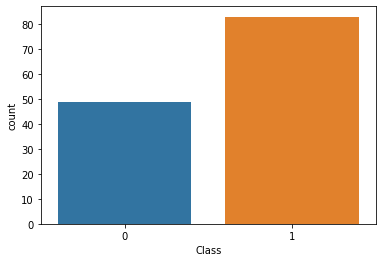

In [42]:
print(hcc_train['Class'].value_counts())
sns.countplot(hcc_train['Class'])

We can see that this is the case of __imbalance dataset__. We are gonna do __random undersampling__ which basically consists of removing data in order to have a more balanced dataset
and thus avoiding our models to __overfitting__. 

## 6. Random Undersampling and Oversampling

![alt text](Sampling_methods.jpg "Title")

### 6.1 Random UnderSampling

In [43]:
# Undersampling the majority class
died = hcc_train.loc[hcc_train ['Class']== 0]
survived = hcc_train.loc[hcc_train ['Class']==1][:49]
random_under = pd.concat([died,survived])

# Shuffling the dataframe rows
random_under = random_under.sample(frac =1, random_state = 42)

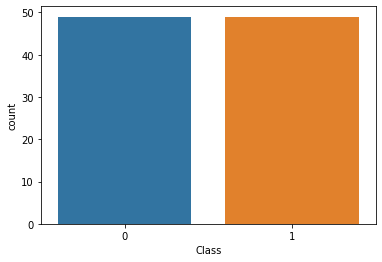

In [44]:
#checking the distribution after the undersampling
sns.countplot(random_under['Class'])

In [45]:
# Training the model with this sample dataset
X_under = random_under.loc[:, random_under.columns != 'Class']
y_under = random_under['Class']

In [46]:
#Checking the dataset for undersampled dataset
print(X_under.shape)
print(y_under.shape)

(98, 39)
(98,)


#### User defined function to train the model and predict

In [47]:
#function to fit and predict
def get_predictions(clf,X_train,y_train,X_test):
    clf =clf # Create classifier
    clf.fit(X_train,y_train)
    #Predict using this test
    y_pred = clf.predict(X_test)
    return y_pred

#### User defined function to get the scores.

In [48]:
def print_scores(y_test,y_pred):
    #print("Confusion Matrix :",confusion_matrix(y_test,y_pred))
    print("recall score:", recall_score(y_test,y_pred))
    print("precision_score:", precision_score(y_test,y_pred))
    print("f1_score:", f1_score(y_test,y_pred))

### 6.2 Getting the scores of the data using Random Undersampling
when the model is trained with random sample set and predicted on the original data

###  LogisticRegression

In [49]:
logreg = LogisticRegression()
logreg.fit(X_under,y_under)
y_prediction = logreg.predict(hcc_test)
print_scores(y_test,y_prediction)

recall score: 0.7368421052631579
precision_score: 0.8235294117647058
f1_score: 0.7777777777777778


### Gaussian Naive Bayes

In [50]:
naive= GaussianNB()
naive.fit(X_under,y_under)
y_predictions1 = naive.predict(hcc_test)
print_scores(y_test,y_predictions1)

recall score: 0.7368421052631579
precision_score: 0.875
f1_score: 0.7999999999999999


### Random Forest

In [51]:
rf= RandomForestClassifier()
rf.fit(X_under,y_under)
y_predictions2 = rf.predict(hcc_test)
print_scores(y_test,y_predictions2)

recall score: 0.5789473684210527
precision_score: 0.9166666666666666
f1_score: 0.7096774193548387


### SVM

In [52]:
svc = SVC(kernel='linear', class_weight=None, C=1.0, random_state=0)

# Train classifier
model = svc.fit(X_under, y_under)
Ypredict_test = model.predict(hcc_test)
print_scores(y_test,Ypredict_test)

recall score: 0.7894736842105263
precision_score: 0.7894736842105263
f1_score: 0.7894736842105263


### 6.3 Oversampling using SMOTE(Synthetic Minority Oversampling Technique)

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![alt text](smote.jpg "Title")

In [53]:
# pip install --upgrade pip

In [54]:
# pip install -U imbalanced-learn

In [55]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')

X_over = hcc_train.loc[:, hcc_train.columns != 'Class']
X_sm, y_sm = smote.fit_sample(X_over, y_train)

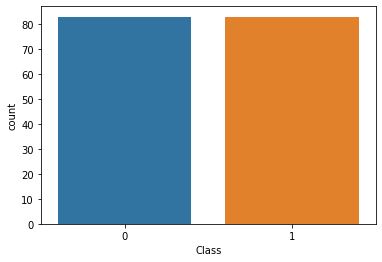

In [56]:
sns.countplot(y_sm)

### 6.4 Getting the scores of the data using Random Oversampling (SMOTE)
when the model is trained with Over sample set and predicted on the original data

###  LogisticRegression

In [57]:
logreg = LogisticRegression()
logreg.fit(X_sm,y_sm)
y_prediction = logreg.predict(hcc_test)
print_scores(y_test,y_prediction)

recall score: 0.8421052631578947
precision_score: 0.8
f1_score: 0.8205128205128205


### Gaussian Naive Bayes

In [58]:
naive= GaussianNB()
naive.fit(X_sm,y_sm)
y_predictions1 = naive.predict(hcc_test)
print_scores(y_test,y_predictions1)

recall score: 0.7894736842105263
precision_score: 0.7142857142857143
f1_score: 0.7500000000000001


### Random Forest

In [59]:
rf= RandomForestClassifier()
rf.fit(X_sm,y_sm)
y_predictions2 = rf.predict(hcc_test)
print_scores(y_test,y_predictions2)

recall score: 0.6842105263157895
precision_score: 0.7647058823529411
f1_score: 0.7222222222222222


### SVM

In [60]:
svc = SVC(kernel='linear', class_weight=None, C=1.0, random_state=0)

# Train classifier
model = svc.fit(X_sm, y_sm)
Ypredict_test = model.predict(hcc_test)
print_scores(y_test,Ypredict_test)


recall score: 0.7368421052631579
precision_score: 0.7777777777777778
f1_score: 0.7567567567567567


### PCA on Oversampled data

In [61]:
from sklearn.decomposition import PCA
pca = PCA(0.95).fit(X_sm)

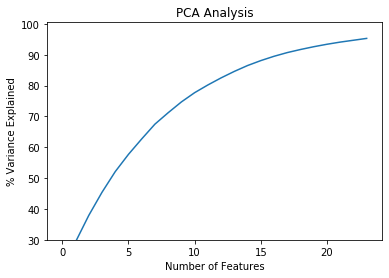

In [62]:
# Graph to plot variance w.r.t features
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [63]:
pca = PCA(n_components=20, random_state = 0)
pca.fit(X_sm)
hcc_train_pca = pca.transform(X_sm)
hcc_test_pca = pca.transform(hcc_test)
print(hcc_train_pca.shape)
print(hcc_test_pca.shape)

(166, 20)
(33, 20)


### PCA + LogisticRegression

In [64]:
logreg = LogisticRegression()
logreg.fit(hcc_train_pca,y_sm)
y_prediction = logreg.predict(hcc_test_pca)
print_scores(y_test,y_prediction)

recall score: 0.7368421052631579
precision_score: 0.7368421052631579
f1_score: 0.7368421052631579


### PCA + Gaussian Naive Bayes

In [65]:
naive= GaussianNB()
naive.fit(hcc_train_pca,y_sm)
y_predictions1 = naive.predict(hcc_test_pca)
print_scores(y_test,y_predictions1)

recall score: 0.7368421052631579
precision_score: 0.6666666666666666
f1_score: 0.7


### PCA + RandomForest

In [66]:
rf= RandomForestClassifier()
rf.fit(hcc_train_pca,y_sm)
y_predictions2 = rf.predict(hcc_test_pca)
print_scores(y_test,y_predictions2)

recall score: 0.8421052631578947
precision_score: 0.7272727272727273
f1_score: 0.7804878048780488


### PCA + SVM

In [67]:
svc = SVC(kernel='linear', class_weight=None, C=1.0, random_state=0)

# Train classifier
model = svc.fit(hcc_train_pca,y_sm)

Ypredict_test = model.predict(hcc_test_pca)
print_scores(y_test,Ypredict_test)


recall score: 0.631578947368421
precision_score: 0.6666666666666666
f1_score: 0.6486486486486486


## 7. Conclusion :

- The hcc_survival data had many missing values which are handled. The oulier treatment is done using Capping or Censoring technique
- As the data available is a case of imbalanced dataset, methods like Random undersampling and Oversampling technique SMOTE is implemented.
- Due to the less avaialability of data we will consider Random Oversampling technique for this dataset.
- Used different classification algorithms: Logistic regression, Naive Bayes, Random Forest and SVM on this dataset
- PCA doesnt seem to have much impact due to the lesser number of components.
- From the F1 score values , we will consider this Logistic regression(__f1_score: 0.8__) as the best fit for this dataset